In [382]:
# Import potrzebnych bibliotek
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from random import sample
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier

### Pobierz i wczytaj zbiór danych SMS Spam Collection

In [2]:
# W pierwszej kolejności zmieniłam typ pobranego pliku SMSSpamCollecion na tekstowy
# Wczytywanie danych
ok=False
while ok==False:
    filepath = input('Wpisz ścieżkę do pliku: ')

    try:
        data = pd.read_csv(filepath, sep = "\t", header = None)
        ok=True
    except FileNotFoundError:
        print('Nieprawidłowa ścieżka. Spróbuj ponownie: ')
        ok=False
#smsspamcollection/SMSSpamCollection.txt

Wpisz ścieżkę do pliku: smsspamcollection/SMSSpamCollection.txt


In [3]:
data.columns = ['Class', 'Message']
data

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Dokonaj eksploracyjnej analizy danych

In [4]:
classes = data['Class'].unique() # W zbiorze występują dwie klasy: 'ham' oraz 'spam'
print(classes)

['ham' 'spam']


In [5]:
# Ilość próbek w każdej z klas
summary_of_class_quantity = data['Class'].value_counts()
print(summary_of_class_quantity)

ham     4825
spam     747
Name: Class, dtype: int64


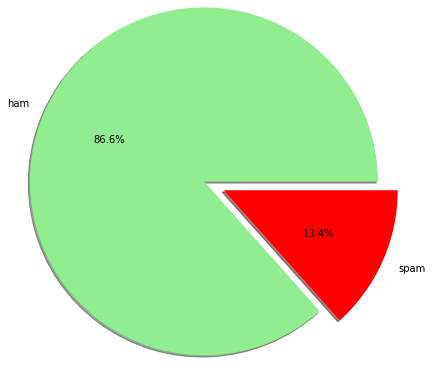

In [6]:
ham_amount = summary_of_class_quantity[0]
spam_amount = summary_of_class_quantity[1]
explode_pie = (0.25, 0)

plt.pie(summary_of_class_quantity, explode=explode_pie, labels=classes, autopct='%1.1f%%', colors=['lightgreen','red'], shadow=True, radius=2)
plt.show()

<div style = "text-align: justify">Jak można zauważyć na wykresie zdecydowana większość wiadomości w zbiorze danych, to&nbsp;wiadomości 'ham'. Stanowią one 86.6% próbek zbioru. Natomiast niechciane wiadomości 'spam' stanowią tylko 13.4% zawartości zbioru. Taka różnica w proporcji występujących klas może mieć znaczenie podczas uczenia klasyfikatora i późniejszej klasyfikacji.

In [7]:
# Sprawdzenie czy wszystkie wiadomości są unikatowe
data['Message'].is_unique

False

**Wniosek:** W zbiorze istnieją wiadomości, które się powtarzają.

In [8]:
#Wyświetlenie 10 najczęściej powtarzających się wiadomości typu 'spam'
repeated_spam = pd.DataFrame(Counter(data['Message'][data['Class']=='spam']).most_common(10))
repeated_spam.columns = ['Spam message', 'Number of occurences']
repeated_spam

,Spam message,Number of occurences
0,Please call our customer service representativ...,4
1,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...,3
2,"Loan for any purpose £500 - £75,000. Homeowner...",3
3,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,3
4,I don't know u and u don't know me. Send CHAT ...,3
5,Camera - You are awarded a SiPix Digital Camer...,3
6,Free entry in 2 a wkly comp to win FA Cup fina...,2
7,WINNER!! As a valued network customer you have...,2
8,Had your mobile 11 months or more? U R entitle...,2
9,"SIX chances to win CASH! From 100 to 20,000 po...",2


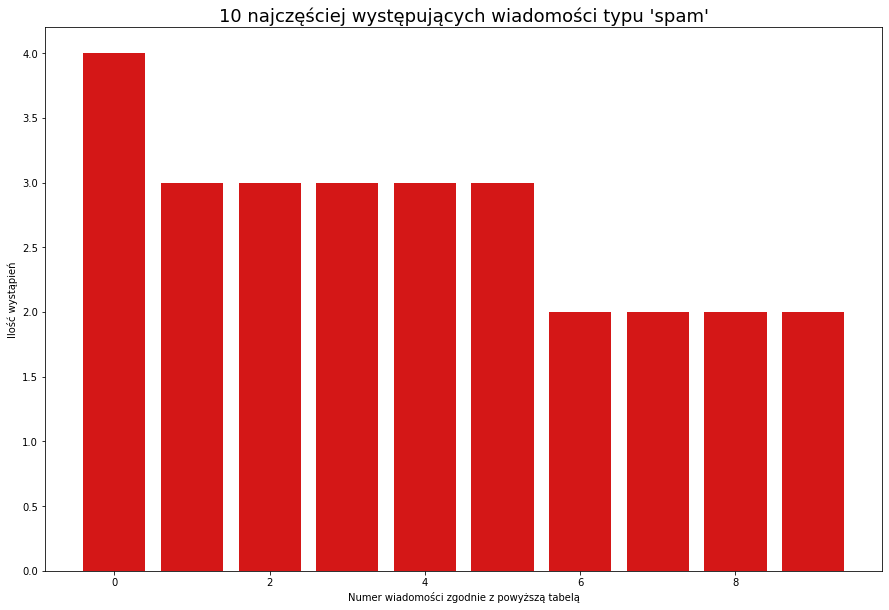

In [9]:
plt.figure(figsize=(15,10))
plt.bar(np.arange(10),repeated_spam['Number of occurences'],color='#d41717')
plt.title("10 najczęściej występujących wiadomości typu 'spam'", fontsize=18)
plt.xlabel('Numer wiadomości zgodnie z powyższą tabelą')
plt.ylabel('Ilość wystąpień')
plt.show()

**Wniosek:** 10 najczęściej powtarzających się wiadomości typu 'spam' powtarza się między 2 a 4 razy. Najczęście potarzająca się wiadomość rozpoczyna się od "Please call our customer servece representative..."

In [10]:
#Wyświetlenie 10 najczęściej powtarzających się wiadomości typu 'ham'
repeated_ham = pd.DataFrame(Counter(data['Message'][data['Class']=='ham']).most_common(10))
repeated_ham.columns = ['Ham message', 'Number of occurences']
repeated_ham

,Ham message,Number of occurences
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,"Wen ur lovable bcums angry wid u, dnt take it ...",4
4,Your opinion about me? 1. Over 2. Jada 3. Kusr...,4
5,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
6,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4
7,Ok,4
8,Ok.,4
9,Okie,4


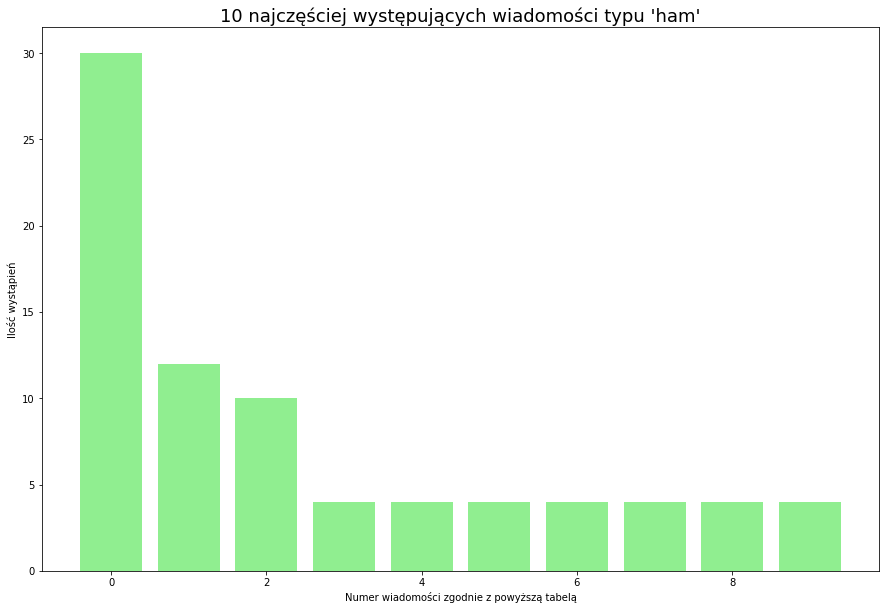

In [11]:
plt.figure(figsize=(15,10))
plt.bar(np.arange(10),repeated_ham['Number of occurences'],color='lightgreen')
plt.title("10 najczęściej występujących wiadomości typu 'ham'", fontsize=18)
plt.xlabel('Numer wiadomości zgodnie z powyższą tabelą')
plt.ylabel('Ilość wystąpień')
plt.show()

**Wniosek:** 10 najczęściej powtarzających się wiadomości typu 'ham' powtarza się między 30 a 4 razy. Najczęście potarzająca się wiadomość to "Sorry, I'll call later".

In [12]:
#Sprawdzenie, czy któraś z wiadomości występuje w obu klasach
data['Message'][data['Class']=='spam'].isin(data['Message'][data['Class']=='ham']).any()

False

**Wniosek:** Żadna z wiadomości nie występuje w obu klasach na raz.

In [13]:
#Sprawdzenie długości wiadomości
messages_length = []
for i in range(data.shape[0]):
    message_length = len(data['Message'][i])
    messages_length.append(message_length)

In [14]:
repeated_messages_length = pd.DataFrame(Counter(messages_length).most_common(300))
repeated_messages_length.columns = ['Długość wiadomości', 'Ilość wystąpień']
repeated_messages_length

,Długość wiadomości,Ilość wystąpień
0,22,120
1,32,99
2,24,99
3,23,95
4,28,87
...,...,...
269,350,1
270,256,1
271,228,1
272,251,1


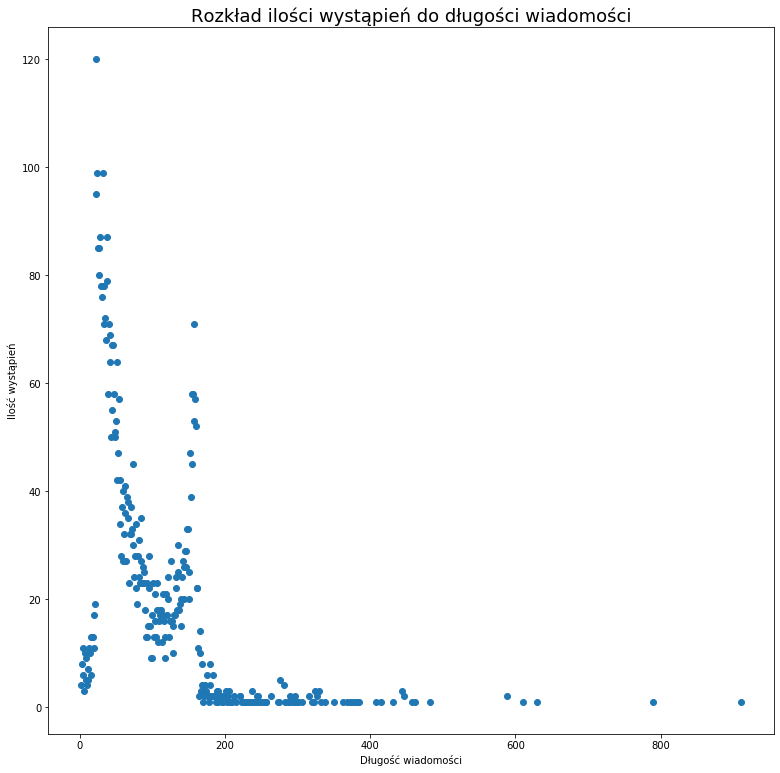

In [15]:
#%matplotlib qt
%matplotlib inline
plt.figure(figsize=(13,13))
plt.scatter(repeated_messages_length['Długość wiadomości'], repeated_messages_length['Ilość wystąpień'])
plt.title('Rozkład ilości wystąpień do długości wiadomości', fontsize=18)
plt.xlabel('Długość wiadomości')
plt.ylabel('Ilość wystąpień')
plt.show()

**Wniosek:** W ziorze wiadomości osiągają 274 różne długości. Najdłuższa wiadomość składa się z 910 znaków, najkrótsza - z 2 znaków. Większość wiadomości zawiera między 20 a 160 znaków. Najczęściej występująca długość wiadomości to 22 znaki (120 wystąpień).

In [16]:
#Najczęściej występujące słowa w całym zbiorze
most_common_words = pd.DataFrame(Counter(" ".join(data['Message'].str.lower()).split()).most_common(16))
most_common_words.columns = ['Słowo', 'Ilość wystąpień']
most_common_words

,Słowo,Ilość wystąpień
0,to,2237
1,i,2217
2,you,1921
3,a,1433
4,the,1329
5,u,998
6,and,968
7,is,869
8,in,859
9,my,755


In [17]:
#Najczęściej występujące słowa w wiadomościach 'ham'
most_common_ham_words = pd.DataFrame(Counter(" ".join(data['Message'][data['Class']=='ham'].str.lower()).split()).most_common(16))
most_common_ham_words.columns = ['Słowo', 'Ilość wystąpień']
most_common_ham_words

,Słowo,Ilość wystąpień
0,i,2181
1,you,1669
2,to,1552
3,the,1125
4,a,1058
5,u,881
6,and,846
7,in,790
8,my,745
9,is,717


In [18]:
#Najczęściej występujące słowa w wiadomościach 'spam'
most_common_spam_words = pd.DataFrame(Counter(" ".join(data['Message'][data['Class']=='spam'].str.lower()).split()).most_common(16))
most_common_spam_words.columns = ['Słowo', 'Ilość wystąpień']
most_common_spam_words

,Słowo,Ilość wystąpień
0,to,685
1,a,375
2,call,342
3,your,263
4,you,252
5,the,204
6,for,202
7,or,188
8,free,180
9,2,169


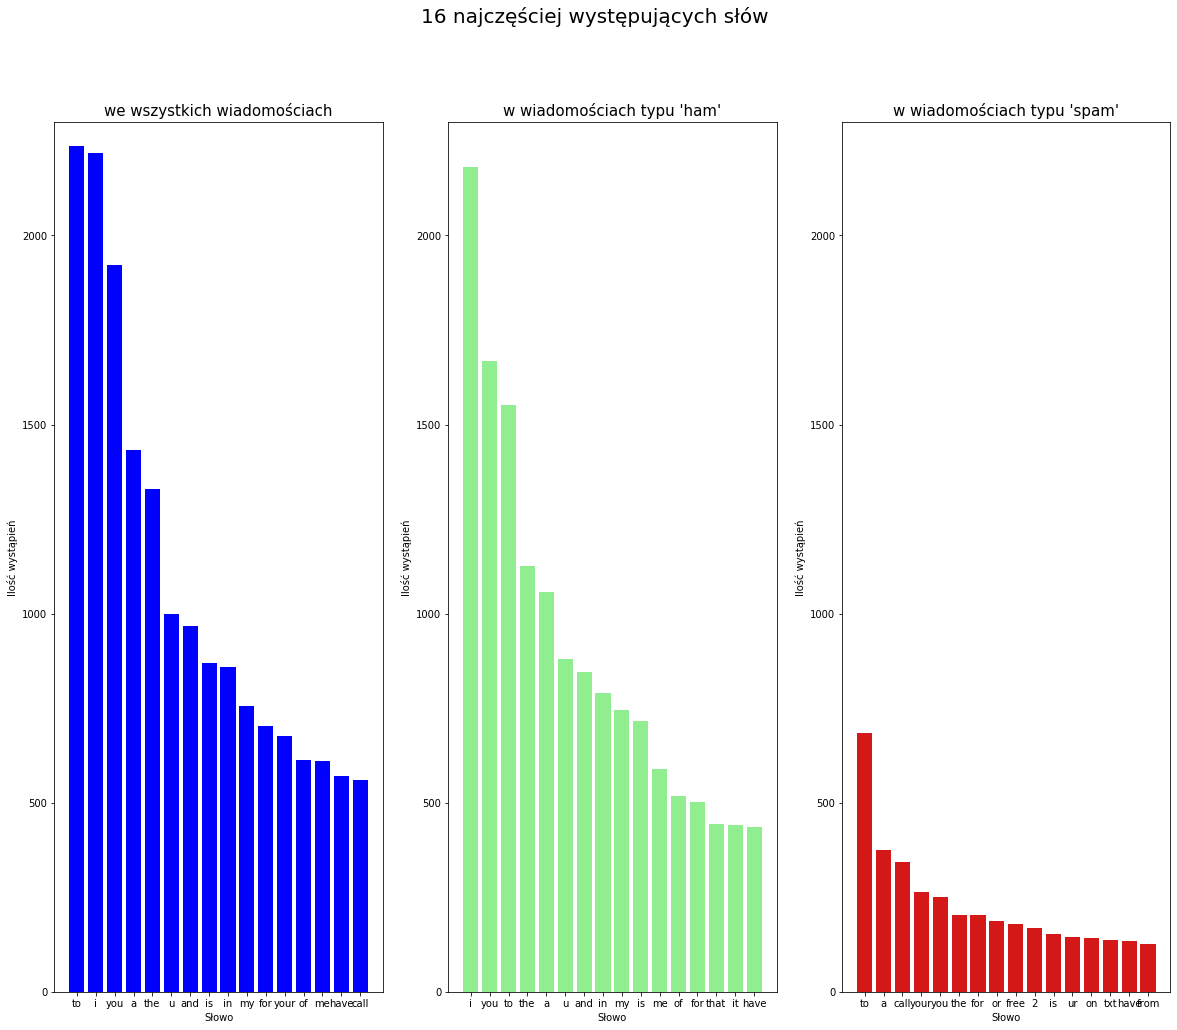

In [19]:
plt.figure(figsize=(20,16))
plt.suptitle("16 najczęściej występujących słów", fontsize=20)

plt.subplot(131)
plt.bar(most_common_words['Słowo'],most_common_words['Ilość wystąpień'],color='b')
plt.title("we wszystkich wiadomościach", fontsize=15)
plt.ylim(0,2300)
plt.xlabel('Słowo')
plt.ylabel('Ilość wystąpień')

plt.subplot(132)
plt.bar(most_common_ham_words['Słowo'],most_common_ham_words['Ilość wystąpień'],color='lightgreen')
plt.title("w wiadomościach typu 'ham'", fontsize=15)
plt.ylim(0,2300)
plt.xlabel('Słowo')
plt.ylabel('Ilość wystąpień')

plt.subplot(133)
plt.bar(most_common_spam_words['Słowo'],most_common_spam_words['Ilość wystąpień'],color='#d41717')
plt.title("w wiadomościach typu 'spam'", fontsize=15)
plt.ylim(0,2300)
plt.xlabel('Słowo')
plt.ylabel('Ilość wystąpień')
plt.show()

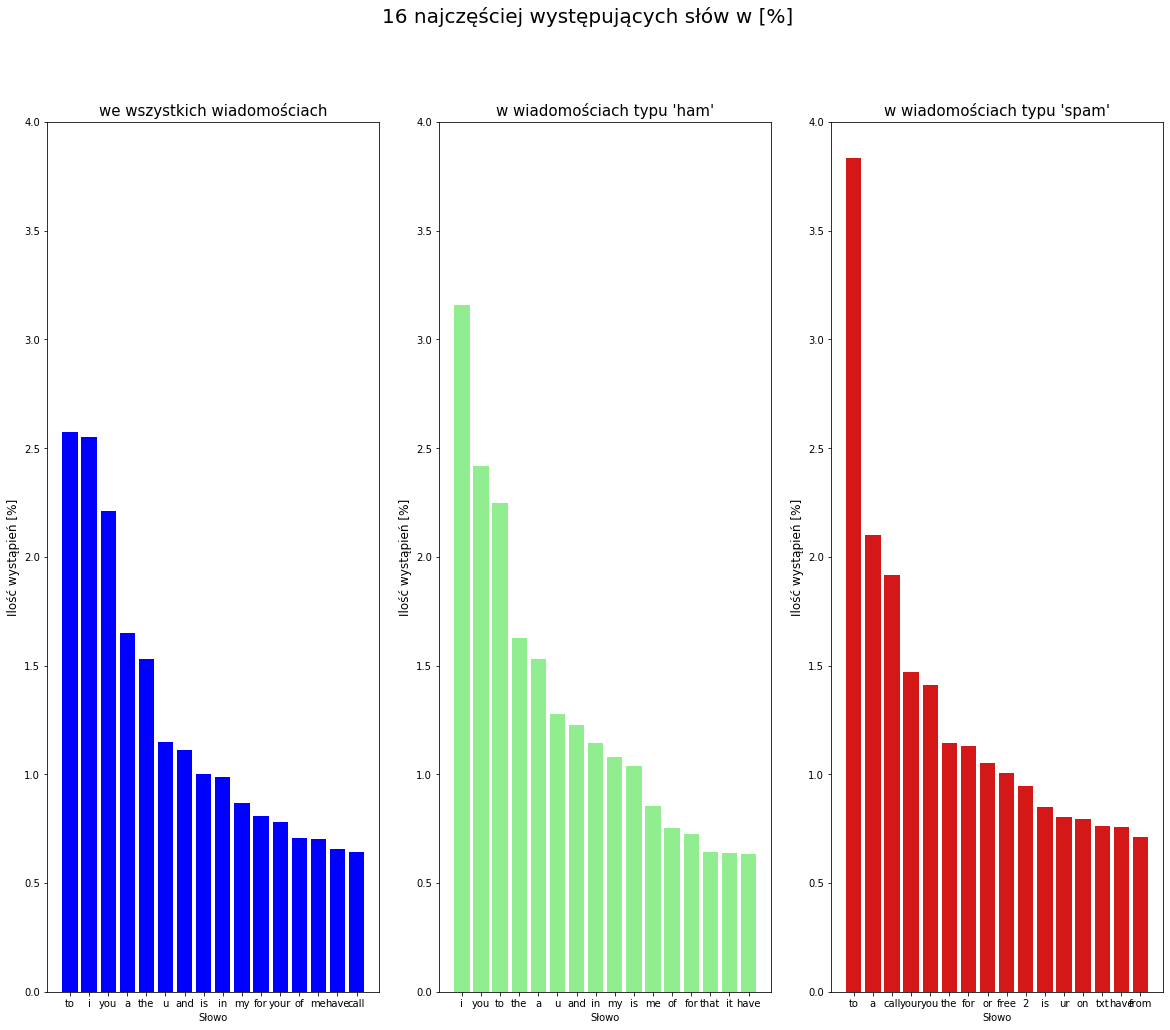

In [30]:
all_words_sum = len(" ".join(data['Message']).split())
ham_words_sum = len(" ".join(data['Message'][data['Class']=='ham']).split())
spam_words_sum = len(" ".join(data['Message'][data['Class']=='spam']).split())


fig, axs = plt.subplots(1,3, gridspec_kw={'wspace': 0.18}, figsize=(20,16))
fig.suptitle("16 najczęściej występujących słów w [%]", fontsize=20)

axs[0].bar(most_common_words['Słowo'],most_common_words['Ilość wystąpień']/all_words_sum*100,color='b')
axs[0].set_title("we wszystkich wiadomościach", fontsize=15)
axs[0].set_xlabel('Słowo')
axs[0].set_ylim(0,4)
axs[0].set_ylabel('Ilość wystąpień [%]', fontsize=12)

axs[1].bar(most_common_ham_words['Słowo'],most_common_ham_words['Ilość wystąpień']/ham_words_sum*100,color='lightgreen')
axs[1].set_title("w wiadomościach typu 'ham'", fontsize=15)
axs[1].set_xlabel('Słowo')
axs[1].set_ylim(0,4)
axs[1].set_ylabel('Ilość wystąpień [%]', fontsize=12)

axs[2].bar(most_common_spam_words['Słowo'],most_common_spam_words['Ilość wystąpień']/spam_words_sum*100,color='#d41717')
axs[2].set_title("w wiadomościach typu 'spam'", fontsize=15)
axs[2].set_xlabel('Słowo')
axs[2].set_ylim(0,4)
axs[2].set_ylabel('Ilość wystąpień [%]', fontsize=12)
plt.show()

<div align="justify"><strong>Wnioski:</strong> W wiadomościach obu typów można zobaczyć różnice w wyrazach, które występują najczęściej. Jednak warto zauważyć, że wśród nich znalazły się w większości mało znaczące słowa, takie jak przyimki, zaimki, przedimki. Pozostałe często stosowane słowa to czasowniki: is, call, have. Dodatkowo wśród najczęściej występujących słowach w wiadomościach typu 'spam' znalazły się także: rzeczownik: txt - prawdopodobnie skrót od text, liczebnik: 2, a także przysłówek: free.  W wiadomościach typu 'spam' słowo your występuje znacznie częściej niż w wiadomościach typu 'ham'. Jest to chyba jedyna cenna uwaga, która mogłaby pomóc w rozróżnianiu obu typów wiadomości na tym etapie analizy. Ponowną analizę należałoby przeprowadzić już po preprocessingu danych.

### Dokonaj preprocessingu danych

In [31]:
data['Message']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object

In [32]:
# Eliminacja znaków interpunkcyjnych z wiadomości
punc = string.punctuation
table = str.maketrans('','',punc)
data['Message'] = data['Message'].apply(lambda x: x.translate(table))

In [33]:
data['Message']

0       Go until jurong point crazy Available only in ...
1                                 Ok lar Joking wif u oni
2       Free entry in 2 a wkly comp to win FA Cup fina...
3             U dun say so early hor U c already then say
4       Nah I dont think he goes to usf he lives aroun...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                  Will ü b going to esplanade fr home
5569    Pity  was in mood for that Soany other suggest...
5570    The guy did some bitching but I acted like id ...
5571                            Rofl Its true to its name
Name: Message, Length: 5572, dtype: object

In [34]:
# Zamiana wielkich liter na małe
data['Message'] = data['Message'].str.lower()
data['Message']

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in 2 a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                  will ü b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: Message, Length: 5572, dtype: object

In [35]:
# Podział wiadomości na tokeny (słowa)
data['Word tokens'] = data.apply(lambda x: x['Message'].split(' '), axis=1)
data

,Class,Message,Word tokens
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,ham,will ü b going to esplanade fr home,"[will, ü, b, going, to, esplanade, fr, home]"
5569,ham,pity was in mood for that soany other suggest...,"[pity, , was, in, mood, for, that, soany, othe..."
5570,ham,the guy did some bitching but i acted like id ...,"[the, guy, did, some, bitching, but, i, acted,..."


In [36]:
# Konwersja tokenów na lemma
lemmatizer = WordNetLemmatizer()
data['Lemmas'] = data.apply(lambda x: [lemmatizer.lemmatize(word, pos="v") for word in x['Word tokens']], axis=1)

In [37]:
data

,Class,Message,Word tokens,Lemmas
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, go, to, usf, he, liv..."
...,...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, be, the, 2nd, time, we, have, try, 2, c..."
5568,ham,will ü b going to esplanade fr home,"[will, ü, b, going, to, esplanade, fr, home]","[will, ü, b, go, to, esplanade, fr, home]"
5569,ham,pity was in mood for that soany other suggest...,"[pity, , was, in, mood, for, that, soany, othe...","[pity, , be, in, mood, for, that, soany, other..."
5570,ham,the guy did some bitching but i acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, do, some, bitch, but, i, act, like,..."


In [38]:
#Porównanie wynik lemmizacji z wynikiem działania oryginalnego algorytmu Portera dla losowych 8 wiadomości z każdej klasy
ps = PorterStemmer()

# Wybór 8 wiadomości każdej z klas
ham_choosen_indexes = sample(set(np.where(data["Class"]=='ham')[0]), 8)
spam_choosen_indexes = sample(set(np.where(data["Class"]=='spam')[0]), 8)
set_of_8_ham_messages = data.iloc[ham_choosen_indexes,:]
set_of_8_spam_messages = data.iloc[spam_choosen_indexes,:]

In [39]:
set_of_8_ham_messages

,Class,Message,Word tokens,Lemmas
3916,ham,ard 530 lor i ok then message ü lor,"[ard, 530, lor, i, ok, then, message, ü, lor]","[ard, 530, lor, i, ok, then, message, ü, lor]"
2135,ham,if he started searching he will get job in few...,"[if, he, started, searching, he, will, get, jo...","[if, he, start, search, he, will, get, job, in..."
4451,ham,awesome be there in a minute,"[awesome, be, there, in, a, minute]","[awesome, be, there, in, a, minute]"
4710,ham,haha awesome i might need to take you up on th...,"[haha, awesome, i, might, need, to, take, you,...","[haha, awesome, i, might, need, to, take, you,..."
884,ham,dude we should go sup again,"[dude, we, should, go, sup, again]","[dude, we, should, go, sup, again]"
2901,ham,come aftr ltdecimalgt now i m cleaning the house,"[come, aftr, , ltdecimalgt, now, i, m, cleanin...","[come, aftr, , ltdecimalgt, now, i, m, clean, ..."
3820,ham,sorry brah just finished the last of my exams ...,"[sorry, brah, just, finished, the, last, of, m...","[sorry, brah, just, finish, the, last, of, my,..."
3135,ham,ok going to sleep hope i can meet her,"[ok, going, to, sleep, hope, i, can, meet, her]","[ok, go, to, sleep, hope, i, can, meet, her]"


In [40]:
set_of_8_spam_messages

,Class,Message,Word tokens,Lemmas
4011,spam,wan2 win a meetgreet with westlife 4 u or a m8...,"[wan2, win, a, meetgreet, with, westlife, 4, u...","[wan2, win, a, meetgreet, with, westlife, 4, u..."
3092,spam,lord of the ringsreturn of the king in store n...,"[lord, of, the, ringsreturn, of, the, king, in...","[lord, of, the, ringsreturn, of, the, king, in..."
3530,spam,xmas new years eve tickets are now on sale fr...,"[xmas, , new, years, eve, tickets, are, now, o...","[xmas, , new, years, eve, ticket, be, now, on,..."
3289,spam,someone u know has asked our dating service 2 ...,"[someone, u, know, has, asked, our, dating, se...","[someone, u, know, have, ask, our, date, servi..."
3463,spam,bloomberg message center 447797706009 why wait...,"[bloomberg, message, center, 447797706009, why...","[bloomberg, message, center, 447797706009, why..."
2804,spam,freemsgfav xmas tonesreply real,"[freemsgfav, xmas, tonesreply, real]","[freemsgfav, xmas, tonesreply, real]"
1518,spam,our brand new mobile music service is now live...,"[our, brand, new, mobile, music, service, is, ...","[our, brand, new, mobile, music, service, be, ..."
1072,spam,urgent we are trying to contact u todays draw ...,"[urgent, we, are, trying, to, contact, u, toda...","[urgent, we, be, try, to, contact, u, todays, ..."


In [41]:
# Porównanie dla wiadomości typu 'ham'
stemmed_ham_messages = set_of_8_ham_messages.apply(lambda x: [ps.stem(word) for word in x['Word tokens']],axis=1)

In [42]:
stemmed_ham_messages.values

array([list(['ard', '530', 'lor', 'i', 'ok', 'then', 'messag', 'ü', 'lor']),
       list(['if', 'he', 'start', 'search', 'he', 'will', 'get', 'job', 'in', 'few', 'daysh', 'have', 'great', 'potenti', 'and', 'talent']),
       list(['awesom', 'be', 'there', 'in', 'a', 'minut']),
       list(['haha', 'awesom', 'i', 'might', 'need', 'to', 'take', 'you', 'up', 'on', 'that', 'what', 'you', 'doin', 'tonight']),
       list(['dude', 'we', 'should', 'go', 'sup', 'again']),
       list(['come', 'aftr', '', 'ltdecimalgt', 'now', 'i', 'm', 'clean', 'the', 'hous']),
       list(['sorri', 'brah', 'just', 'finish', 'the', 'last', 'of', 'my', 'exam', 'what', 'up']),
       list(['ok', 'go', 'to', 'sleep', 'hope', 'i', 'can', 'meet', 'her'])],
      dtype=object)

In [43]:
set_of_8_ham_messages['Lemmas'].values

array([list(['ard', '530', 'lor', 'i', 'ok', 'then', 'message', 'ü', 'lor']),
       list(['if', 'he', 'start', 'search', 'he', 'will', 'get', 'job', 'in', 'few', 'dayshe', 'have', 'great', 'potential', 'and', 'talent']),
       list(['awesome', 'be', 'there', 'in', 'a', 'minute']),
       list(['haha', 'awesome', 'i', 'might', 'need', 'to', 'take', 'you', 'up', 'on', 'that', 'what', 'you', 'doin', 'tonight']),
       list(['dude', 'we', 'should', 'go', 'sup', 'again']),
       list(['come', 'aftr', '', 'ltdecimalgt', 'now', 'i', 'm', 'clean', 'the', 'house']),
       list(['sorry', 'brah', 'just', 'finish', 'the', 'last', 'of', 'my', 'exams', 'what', 'up']),
       list(['ok', 'go', 'to', 'sleep', 'hope', 'i', 'can', 'meet', 'her'])],
      dtype=object)

In [44]:
stemmed_ham_messages == set_of_8_ham_messages['Lemmas']

3916    False
2135    False
4451    False
4710    False
884      True
2901    False
3820    False
3135     True
dtype: bool

<div align="justify"><strong>Wnioski:</strong> Tylko dwie z ośmiu wiadomości zostały przetworzone w taki sam sposób przez w wyniku lemmizacji i działania oryginalnego algorytmu Portera. W wyniku lemmizacji można otrzymać podstawowe formy danej części mowy, np. czasowników. Tymczasem algorytm Portera skraca rzeczowniki do ich podstawy słowotwórczej lub - w przypadku występowania 'y' na końcu wyrazu zamienia go na 'i', przez co upodabnia zapis wyrazu do jego wymowy.

In [45]:
# Porównanie dla wiadomości typu 'spam'
stemmed_spam_messages = set_of_8_spam_messages.apply(lambda x: [ps.stem(word) for word in x['Word tokens']],axis=1)

In [46]:
stemmed_spam_messages.values

array([list(['wan2', 'win', 'a', 'meetgreet', 'with', 'westlif', '4', 'u', 'or', 'a', 'm8', 'they', 'are', 'current', 'on', 'what', 'tour', '1unbreak', '2untam', '3unkempt', 'text', '12', 'or', '3', 'to', '83049', 'cost', '50p', 'std', 'text']),
       list(['lord', 'of', 'the', 'ringsreturn', 'of', 'the', 'king', 'in', 'store', 'nowrepli', 'lotr', 'by', '2', 'june', '4', 'chanc', '2', 'win', 'lotr', 'soundtrack', 'cd', 'stdtxtrate', 'repli', 'stop', 'to', 'end', 'txt']),
       list(['xma', '', 'new', 'year', 'eve', 'ticket', 'are', 'now', 'on', 'sale', 'from', 'the', 'club', 'dure', 'the', 'day', 'from', '10am', 'till', '8pm', 'and', 'on', 'thur', 'fri', '', 'sat', 'night', 'thi', 'week', 'theyr', 'sell', 'fast']),
       list(['someon', 'u', 'know', 'ha', 'ask', 'our', 'date', 'servic', '2', 'contact', 'you', 'cant', 'guess', 'who', 'call', '09058097189', 'now', 'all', 'will', 'be', 'reveal', 'pobox', '6', 'ls15hb', '150p', '']),
       list(['bloomberg', 'messag', 'center', '447797

In [47]:
print(set_of_8_spam_messages['Lemmas'].values)

[list(['wan2', 'win', 'a', 'meetgreet', 'with', 'westlife', '4', 'u', 'or', 'a', 'm8', 'they', 'be', 'currently', 'on', 'what', 'tour', '1unbreakable', '2untamed', '3unkempt', 'text', '12', 'or', '3', 'to', '83049', 'cost', '50p', 'std', 'text'])
 list(['lord', 'of', 'the', 'ringsreturn', 'of', 'the', 'king', 'in', 'store', 'nowreply', 'lotr', 'by', '2', 'june', '4', 'chance', '2', 'win', 'lotr', 'soundtrack', 'cds', 'stdtxtrate', 'reply', 'stop', 'to', 'end', 'txts'])
 list(['xmas', '', 'new', 'years', 'eve', 'ticket', 'be', 'now', 'on', 'sale', 'from', 'the', 'club', 'during', 'the', 'day', 'from', '10am', 'till', '8pm', 'and', 'on', 'thurs', 'fri', '', 'sit', 'night', 'this', 'week', 'theyre', 'sell', 'fast'])
 list(['someone', 'u', 'know', 'have', 'ask', 'our', 'date', 'service', '2', 'contact', 'you', 'cant', 'guess', 'who', 'call', '09058097189', 'now', 'all', 'will', 'be', 'reveal', 'pobox', '6', 'ls15hb', '150p', ''])
 list(['bloomberg', 'message', 'center', '447797706009', 'wh

In [48]:
stemmed_spam_messages == set_of_8_spam_messages['Lemmas']

4011    False
3092    False
3530    False
3289    False
3463    False
2804    False
1518    False
1072    False
dtype: bool

<div align="justify"><strong>Wnioski:</strong> Żadne z ośmiu zdań ze zbioru wiadomości 'spam' nie zostało przetworzone w ten sam sposów w wyniku lemmizacji i działania algorytmu Portera. W przypadku wiadomości tego typu można zauważyć podobne zależności w różnicach ich przetwarzania przez oba algorytmy, co w przypadku wiadomości typu 'ham': pozostawanie podstawy słowotwórczej i zamiana występującego na końcu wyrazu 'y' na 'i' przez algorytm Portera oraz zamiana czasowników na ich bezokolicznikowe formy w wyniku lemmizacji.

In [49]:
# Usuwanie słów o małym znaczeniu - wyświetlenie domyślnych małoznaczących słów
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [50]:
'u' in stopwords.words('english')

False

**Wniosek:** Domyślny zbiór słów o niewielkim znaczeniu nie jest wystarczający, aby poradzić sobie ze slangiem SMSowym, ponieważ występuje w nim wiele skrótów, np. 'u' (od 'you'), 'wat' (od 'what'), 'r' (od 'are'), 'ur' (od 'you are'), 'ive' (od 'I have'), 'b' (od 'be'), 'wen' (od when), 'wid' (od 'why do'), 'dnt' (od 'don't').

In [232]:
# Dodanie małoznaczących słów pochodzących ze slangu SMSowego
stopwords_expanded = stopwords.words('english')
SMS_slang = ['u','wat','r','ur','ive','b','wen','wid','dnt', '', 'dont', 'im']
for i in SMS_slang:
    stopwords_expanded.append(i)

In [233]:
stopwords_expanded = set(stopwords_expanded)
stopwords_expanded

{'',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'b',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'dnt',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'dont',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'im',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'ive',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',

In [234]:
# Usuwanie słów o małym znaczeniu
data['Without stop words'] = data.apply(lambda x: [word for word in x['Lemmas'] if word not in stopwords_expanded], axis=1)

In [235]:
data

,Class,Message,Word tokens,Lemmas,Without stop words
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joke, wif, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[dun, say, early, hor, c, already, say]"
4,ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, go, to, usf, he, liv...","[nah, think, go, usf, live, around, though]"
...,...,...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, be, the, 2nd, time, we, have, try, 2, c...","[2nd, time, try, 2, contact, win, £750, pound,..."
5568,ham,will ü b going to esplanade fr home,"[will, ü, b, going, to, esplanade, fr, home]","[will, ü, b, go, to, esplanade, fr, home]","[ü, go, esplanade, fr, home]"
5569,ham,pity was in mood for that soany other suggest...,"[pity, , was, in, mood, for, that, soany, othe...","[pity, , be, in, mood, for, that, soany, other...","[pity, mood, soany, suggestions]"
5570,ham,the guy did some bitching but i acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, do, some, bitch, but, i, act, like,...","[guy, bitch, act, like, id, interest, buy, som..."


In [236]:
# Ponowne wyznaczenie listy najczęściej występujących słów
#Najczęściej występujące słowa w całym zbiorze
words_after_modifications = []
for sentence_lemma in data['Without stop words']:
    for word in sentence_lemma:
        words_after_modifications.append(word)

most_common_words_after_modifications = pd.DataFrame(Counter(words_after_modifications).most_common(16))
most_common_words_after_modifications.columns = ['Słowo', 'Ilość wystąpień']
most_common_words_after_modifications

,Słowo,Ilość wystąpień
0,get,689
1,call,655
2,go,554
3,2,482
4,come,327
5,4,293
6,know,284
7,ok,278
8,ltgt,276
9,free,275


In [237]:
#Najczęściej występujące słowa w wiadomościach 'ham'
ham_words_after_modifications = []
for sentence_lemma in data['Without stop words'][data['Class']=='ham']:
    for word in sentence_lemma:
        ham_words_after_modifications.append(word)

most_common_ham_words_after_modifications = pd.DataFrame(Counter(ham_words_after_modifications).most_common(16))
most_common_ham_words_after_modifications.columns = ['Słowo', 'Ilość wystąpień']
most_common_ham_words_after_modifications

,Słowo,Ilość wystąpień
0,get,595
1,go,519
2,come,321
3,2,309
4,call,289
5,ltgt,276
6,ok,273
7,know,258
8,like,241
9,ill,238


In [238]:
#Najczęściej występujące słowa w wiadomościach 'spam'
spam_words_after_modifications = []
for sentence_lemma in data['Without stop words'][data['Class']=='spam']:
    for word in sentence_lemma:
        spam_words_after_modifications.append(word)

most_common_spam_words_after_modifications = pd.DataFrame(Counter(spam_words_after_modifications).most_common(16))
most_common_spam_words_after_modifications.columns = ['Słowo', 'Ilość wystąpień']
most_common_spam_words_after_modifications

,Słowo,Ilość wystąpień
0,call,366
1,free,216
2,2,173
3,txt,150
4,win,135
5,mobile,123
6,text,120
7,4,119
8,claim,115
9,stop,115


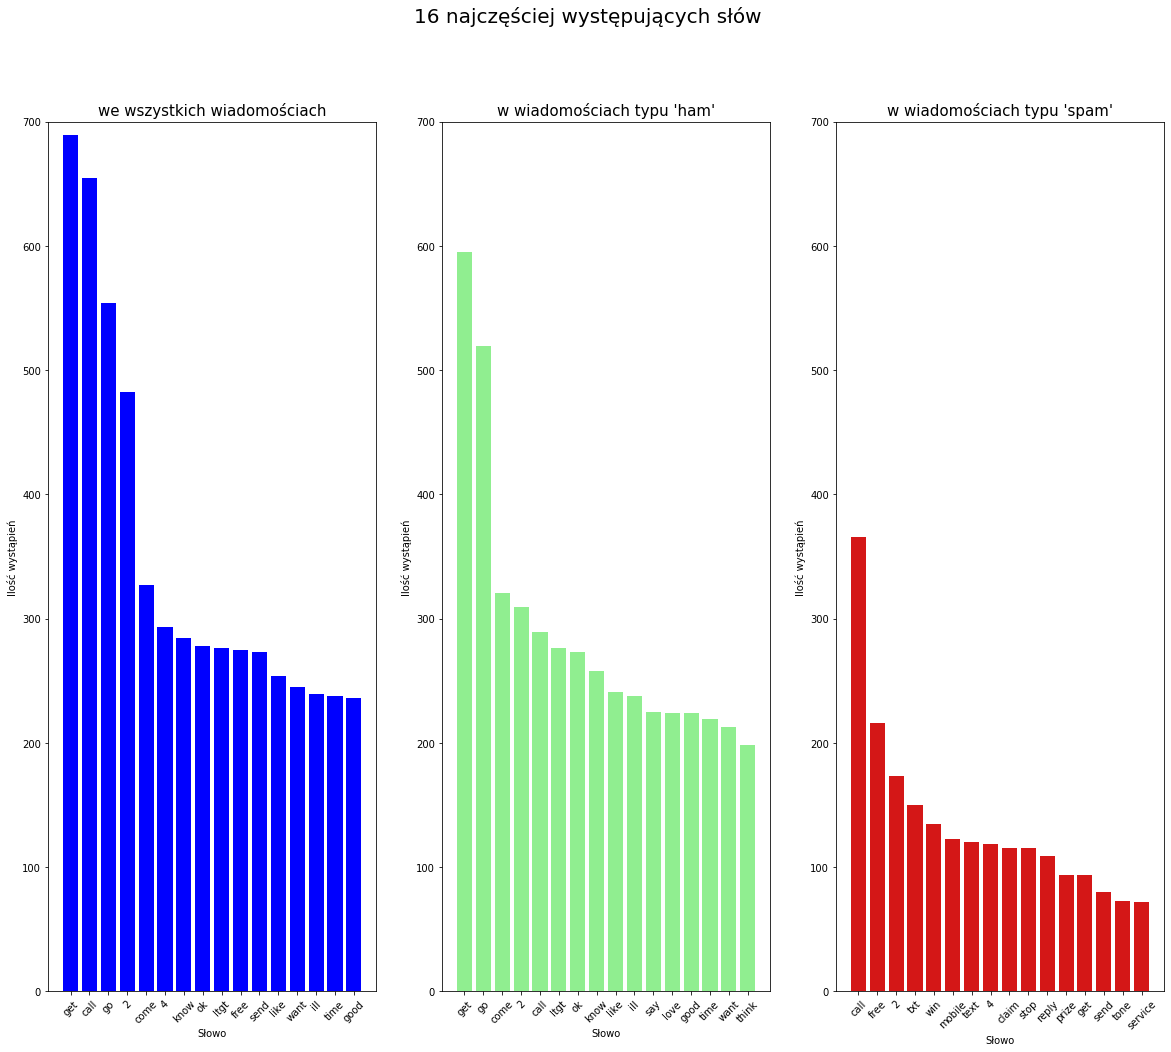

In [239]:
#plt.figure(figsize=(20,16))
plt.subplots(1,3, gridspec_kw={'wspace': 0.1}, figsize=(20,16))
plt.suptitle("16 najczęściej występujących słów", fontsize=20)

plt.subplot(131)
plt.bar(most_common_words_after_modifications['Słowo'],most_common_words_after_modifications['Ilość wystąpień'],color='b')
plt.title("we wszystkich wiadomościach", fontsize=15)
plt.ylim(0,700)
plt.xlabel('Słowo')
plt.xticks(rotation=45)
plt.ylabel('Ilość wystąpień')

plt.subplot(132)
plt.bar(most_common_ham_words_after_modifications['Słowo'],most_common_ham_words_after_modifications['Ilość wystąpień'],color='lightgreen')
plt.title("w wiadomościach typu 'ham'", fontsize=15)
plt.ylim(0,700)
plt.xlabel('Słowo')
plt.xticks(rotation=45)
plt.ylabel('Ilość wystąpień')

plt.subplot(133)
plt.bar(most_common_spam_words_after_modifications['Słowo'],most_common_spam_words_after_modifications['Ilość wystąpień'],color='#d41717')
plt.title("w wiadomościach typu 'spam'", fontsize=15)
plt.ylim(0,700)
plt.xlabel('Słowo')
plt.ylabel('Ilość wystąpień')
plt.xticks(rotation=45)
plt.show()

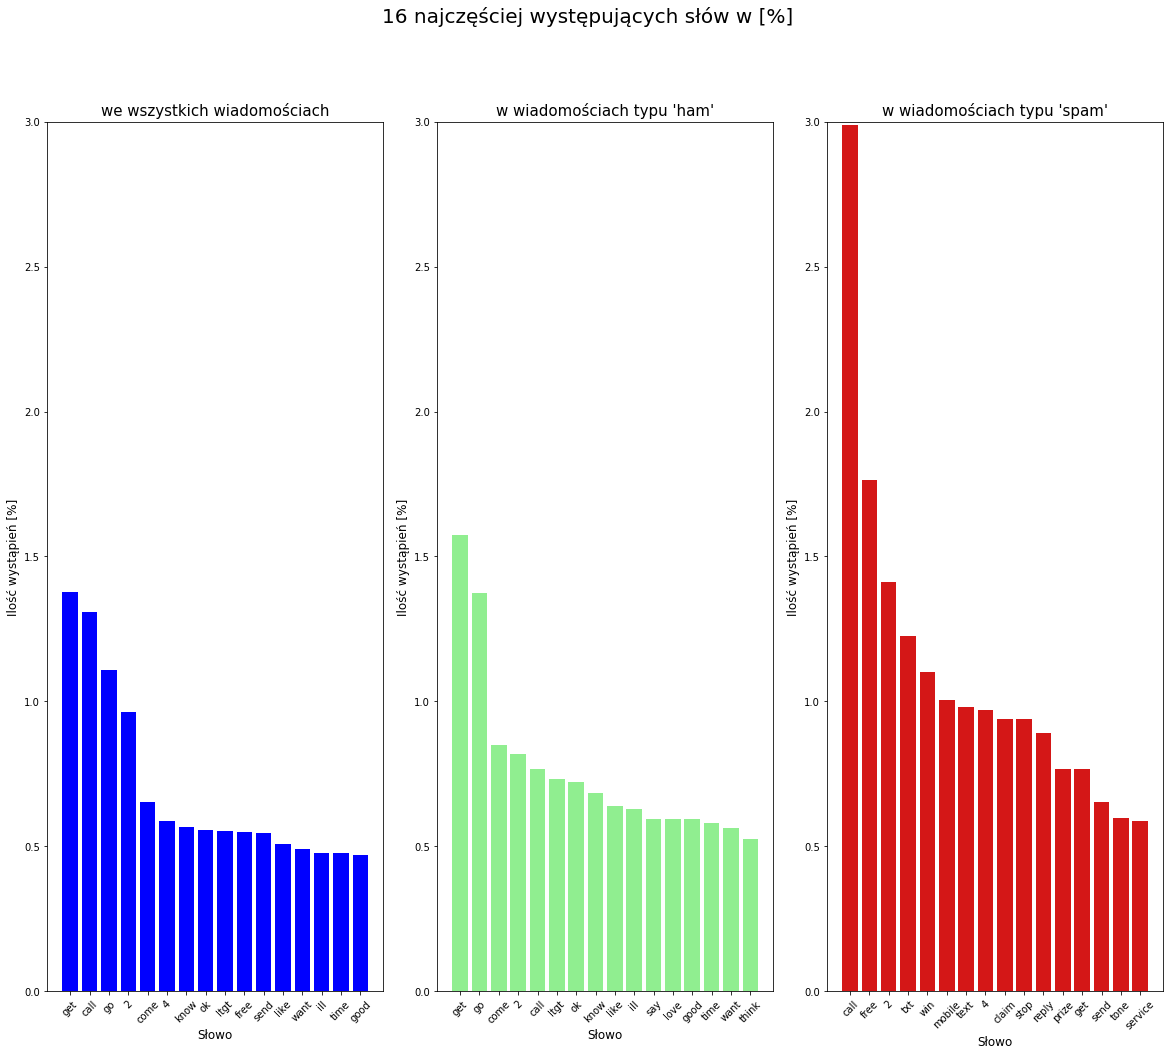

In [241]:
fig, axs = plt.subplots(1,3, gridspec_kw={'wspace': 0.16}, figsize=(20,16))
fig.suptitle("16 najczęściej występujących słów w [%]", fontsize=20)

axs[0].bar(most_common_words_after_modifications['Słowo'],most_common_words_after_modifications['Ilość wystąpień']/len(words_after_modifications)*100,color='b')
axs[0].set_title("we wszystkich wiadomościach", fontsize=15)
axs[0].set_xlabel('Słowo', fontsize=12)
axs[0].set_ylim(0,3)
axs[0].set_ylabel('Ilość wystąpień [%]', fontsize=12)
axs[0].set_xticklabels(most_common_words_after_modifications['Słowo'], rotation=45)

axs[1].bar(most_common_ham_words_after_modifications['Słowo'],most_common_ham_words_after_modifications['Ilość wystąpień']/len(ham_words_after_modifications)*100,color='lightgreen')
axs[1].set_title("w wiadomościach typu 'ham'", fontsize=15)
axs[1].set_xlabel('Słowo', fontsize=12)
axs[1].set_ylim(0,3)
axs[1].set_ylabel('Ilość wystąpień [%]', fontsize=12)
axs[1].set_xticklabels(most_common_ham_words_after_modifications['Słowo'], rotation=45)

axs[2].bar(most_common_spam_words_after_modifications['Słowo'],most_common_spam_words_after_modifications['Ilość wystąpień']/len(spam_words_after_modifications)*100,color='#d41717')
axs[2].set_title("w wiadomościach typu 'spam'", fontsize=15)
axs[2].set_xlabel('Słowo', fontsize=12)
axs[2].set_ylim(0,3)
axs[2].set_ylabel('Ilość wystąpień [%]', fontsize=12)
axs[2].set_xticklabels(most_common_spam_words_after_modifications['Słowo'], rotation=45)
plt.show()

**Wniosek:** Listy najczęściej występujących słów dla każdej z klas jak i dla całego zbioru uległy zmianie - możliwie jest rozróżnienie grup wyrazów charakterystycznych dla wiadomości 'spam' i 'ham'.

In [294]:
# Wektoryzacja lemm na wektory cech - połącznie słów w wiadomości
vectorizer = CountVectorizer()
data['Transformed messages'] = data.apply(lambda x: ' '.join(x['Without stop words']), axis=1)

In [295]:
data

,Class,Message,Word tokens,Lemmas,Without stop words,Transformed messages
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joke, wif, oni]",ok lar joke wif oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[dun, say, early, hor, c, already, say]",dun say early hor c already say
4,ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, go, to, usf, he, liv...","[nah, think, go, usf, live, around, though]",nah think go usf live around though
...,...,...,...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, be, the, 2nd, time, we, have, try, 2, c...","[2nd, time, try, 2, contact, win, £750, pound,...",2nd time try 2 contact win £750 pound prize 2 ...
5568,ham,will ü b going to esplanade fr home,"[will, ü, b, going, to, esplanade, fr, home]","[will, ü, b, go, to, esplanade, fr, home]","[ü, go, esplanade, fr, home]",ü go esplanade fr home
5569,ham,pity was in mood for that soany other suggest...,"[pity, , was, in, mood, for, that, soany, othe...","[pity, , be, in, mood, for, that, soany, other...","[pity, mood, soany, suggestions]",pity mood soany suggestions
5570,ham,the guy did some bitching but i acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, do, some, bitch, but, i, act, like,...","[guy, bitch, act, like, id, interest, buy, som...",guy bitch act like id interest buy something e...


In [303]:
# Wektoryzacja lemm na wektory cech
Vectors = []
for i in range(len(data['Transformed messages'])):
    Vectors.append(data['Transformed messages'][i])

bag = vectorizer.fit_transform(Vectors).toarray()

### Naucz klasyfikator

In [310]:
X = pd.DataFrame(bag)
Y = data['Class'].replace(['ham', 'spam'], [0,1])

In [314]:
# Podział na zbiór treningowy i testowy
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [316]:
# Uczenie naiwnego klasyfikatora Bayesa
bayes_classifier = MultinomialNB()
bayes_classifier.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

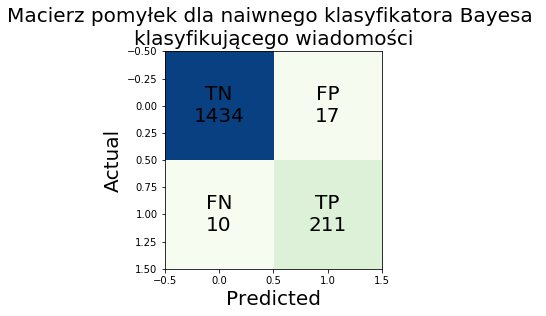

In [318]:
# Wynik klasyfikacji zbioru testowego
y_pred = bayes_classifier.predict(X_test)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.GnBu)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("Actual", fontsize=20)
plt.title("Macierz pomyłek dla naiwnego klasyfikatora Bayesa \nklasyfikującego wiadomości", fontsize=20)
s= [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+"\n"+str(cm[i][j]), fontsize=20, verticalalignment='center', horizontalalignment='center')

<div align="justify"><strong>Wniosek:</strong> Klasyfikator dość dobrze radzi sobie z klasyfikacją wiadomości na spam i ważne dla użutkownika wiadomości, jednak przy założeniu, że klasyfikator będzie automatycznie usuwał spam, należy zminimalizować błędy typu 1, czyli błąd odrzucenia wiadomości, nie będącej w rzeczywistości spamem (FP). Oznacza się go symbolem $\alpha$ i nazywa poziomem istotności testu. Ograniczenie błędu tego typu pozwoli nam uniknąć sytuacji, w której automatyczny klasyfikator usunąłby trwale ważną dla nas wiadomość.

In [ ]:
# Minimalizacja błędu typu 1.

In [341]:
def type_1_error(alpha):
    return confusion_matrix(Y_test, MultinomialNB(alpha).fit(X_train, Y_train).predict(X_test))[0,1]

In [364]:
def minimize_alpha_error(alphas):
    errors = []
    for i in range(len(alphas)):
        errors.append(type_1_error(alphas[i]))
    return alphas[np.where(errors == min(errors))]

In [370]:
alpha1 = np.arange(0.,100,1)
minimize_alpha_error(alpha1)

C:\Users\Ryzen\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


array([13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [375]:
type_1_error(13)

0

**Wniosek:** Błąd typu 1. równy 0 dla badanego zbioru można uzyskać przyjmując wartość $\alpha$ = 13.

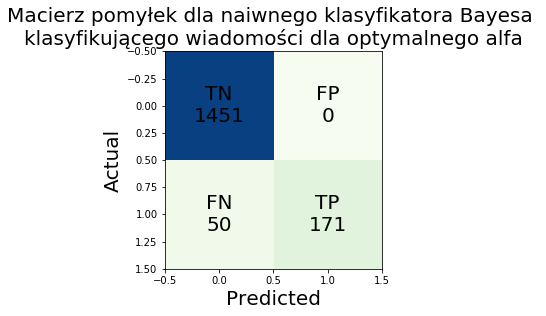

In [376]:
# Uczenie naiwnego klasyfikatora Bayesa z optymalnym alpha
bayes_clf = MultinomialNB(alpha=13)
bayes_clf.fit(X_train, Y_train)

# Wynik klasyfikacji zbioru testowego
y_pred2 = bayes_clf.predict(X_test)

# Confusion matrix
cm2 = confusion_matrix(Y_test, y_pred2)
plt.figure()
plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.GnBu)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("Actual", fontsize=20)
plt.title("Macierz pomyłek dla naiwnego klasyfikatora Bayesa \nklasyfikującego wiadomości dla optymalnego alfa", fontsize=20)
s= [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+"\n"+str(cm2[i][j]), fontsize=20, verticalalignment='center', horizontalalignment='center')

In [381]:
accuracy = np.round(accuracy_score(Y_test, y_pred),4)*100
print("Poprawność klasyfikacji przez naiwny klasyfikator Bayesa wyniosła: ", accuracy, "%")

Poprawność klasyfikacji przez naiwny klasyfikator Bayesa wyniosła:  98.4 %


Poprawność klasyfikacji przez DummyClassifier wyniosła:  86.8 %


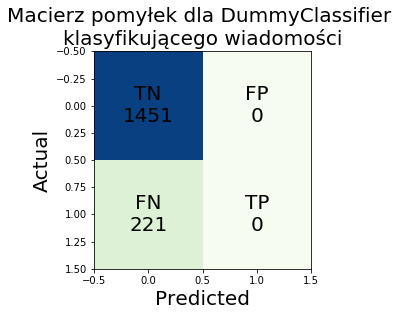

In [387]:
# Uczenie klasyfikatora DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, Y_train)
y_dummy_predicted = dummy_clf.predict(X_test)

# Confusion matrix dla DummyClassifier
cm3 = confusion_matrix(Y_test, y_dummy_predicted)
plt.figure()
plt.imshow(cm3, interpolation='nearest', cmap=plt.cm.GnBu)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("Actual", fontsize=20)
plt.title("Macierz pomyłek dla DummyClassifier \nklasyfikującego wiadomości", fontsize=20)
s= [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+"\n"+str(cm3[i][j]), fontsize=20, verticalalignment='center', horizontalalignment='center')

#Accuracy dla DummyClassifier
accuracy2 = np.round(accuracy_score(Y_test, y_dummy_predicted),3)*100
print("Poprawność klasyfikacji przez DummyClassifier wyniosła: ", accuracy2, "%")

<p><div align="justify"><strong>Wnioski: </strong>Zdecydowanie lepsze wyniki osiągnął naiwny klasyfikator Bayesa - poprawność klasyfikacji wyniosła 98,4%, ilość fałszywie pozytywnych wiadomości wyniosła 0, ponadto klasyfikator ten umiał rozróżnić wiadomości typu 'spam' i typu 'ham'. W 50 przypadkach popełnił błąd uznając spam za wiadomości typu 'ham'.</div></p> 

<p><div align = "justify">Klasyfikator DummyClassifier, który klasyfikował próbki na podstawie tego, których próbek jest więcej w zbiorze osiągnął jedynie 86,8% poprawności. Ilość fałszywie pozytywnych wiadomości wyniosła w jego przypadku również wyniosła 0, jednak klasyfikator ten nie oznaczył żadnej wiadomości jako spam, co jest równoznaczne z tym, że pomylił się w 221 przypadkach.</div></p>

### Klasyfikacja maila

In [389]:
mail = 'Dear Sir: I have been requested by the Nigerian National Petroleum Company to contact you for assistance in resolving a matter. The Nigerian National Petroleum Company has recently concluded a large number of contracts for oil exploration in the sub-Sahara region. The contracts have immediately produced moneys equaling US$40,000,000. The Nigerian National Petroleum Company is desirous of oil exploration in other parts of the world, however, because of certain regulations of the Nigerian Government, it is unable to move these funds to another region. You assistance is requested as a non-Nigerian citizen to assist the Nigerian National Petroleum Company, and also the Central Bank of Nigeria, in moving these funds out of Nigeria. If the funds can be transferred to your name, in your United States account, then you can forward the funds as directed by the Nigerian National Petroleum Company. In exchange for your accommodating services, the Nigerian National Petroleum Company would agree to allow you to retain 10%, or US$4 million of this amount. However, to be a legitimate transferee of these moneys according to Nigerian law, you must presently be a depositor of at least US$100,000 in a Nigerian bank which is regulated by the Central Bank of Nigeria. If it will be possible for you to assist us, we would be most grateful. We suggest that you meet with us in person in Lagos, and that during your visit I introduce you to the representatives of the Nigerian National Petroleum Company, as well as with certain officials of the Central Bank of Nigeria. Please call me at your earliest convenience at 18-467-4975. Time is of the essence in this matter; very quickly the Nigerian Government will realize that the Central Bank is maintaining this amount on deposit, and attempt to levy certain depository taxes on it. Yours truly, Prince Alyusi Islassis'

In [391]:
# Usuwanie znaków interpunkcyjnych
mail_without_punctuation = mail.translate(table)

In [394]:
# Zamiana wszystkich liter na małe
mail_lower_case = mail_without_punctuation.lower()

In [396]:
# Podział wiadomości na tokeny
mail_tokens = mail_lower_case.split(' ')

In [399]:
# Konwersja tokenów na lemma
mail_lemmas = [lemmatizer.lemmatize(word, pos="v") for word in mail_tokens]

In [403]:
# Usuwanie mało znaczących słów
mail_without_stopwords = [word for word in mail_lemmas if word not in stopwords_expanded]

In [405]:
# Utworzenie wiadomości z pozostałych lemm
transformed_mail = ' '.join(mail_without_stopwords)

In [406]:
transformed_mail

'dear sir request nigerian national petroleum company contact assistance resolve matter nigerian national petroleum company recently conclude large number contract oil exploration subsahara region contract immediately produce moneys equal us40000000 nigerian national petroleum company desirous oil exploration part world however certain regulations nigerian government unable move fund another region assistance request nonnigerian citizen assist nigerian national petroleum company also central bank nigeria move fund nigeria fund transfer name unite state account forward fund direct nigerian national petroleum company exchange accommodate service nigerian national petroleum company would agree allow retain 10 us4 million amount however legitimate transferee moneys accord nigerian law must presently depositor least us100000 nigerian bank regulate central bank nigeria possible assist us would grateful suggest meet us person lagos visit introduce representatives nigerian national petroleum c

In [409]:
# Wektoryzacja danych z uwzględnieniem waidomości e-mail
Vectors.append(transformed_mail)
bag2 = vectorizer.fit_transform(Vectors).toarray()

In [414]:
# Wektor cech dla wiadomości mailowej
X_mail = pd.DataFrame(bag2[bag2.shape[0]-1])

In [425]:
# Nowy zbiór danych (zawiera dodatkowe kolumny)
X2 = pd.DataFrame(bag2[:bag2.shape[0]-1,:])

In [427]:
# Uczenie naiwnego klasyfikatora Bayesa z optymalnym alpha - uczenie na podstawie całego zbioru
bayes_clf_2 = MultinomialNB(alpha=13)
bayes_clf_2.fit(X2, Y)

# Wynik klasyfikacji maila
y_pred_mail = bayes_clf_2.predict(X_mail.T)
print("Klasa wiadomości to: ", y_pred_mail)

Klasa wiadomości to:  [0]


<div align="justify"><strong>Wnioski: </strong>0 oznacza wiadomość typu 'ham', co jest niezgodne z rzeczywistością, jednak mail ten doskonale "udaje" ważną wiadomość. Uważam, że mimo, że klasyfikator niepoprawnie sklasyfikował wiadomość, jest ona na tyle nietypowa, że jej ocena powinna należeć do użytkownika. Mail ma strukturę i zdania typowe dla oficjalnej korespondencji. Dopiero przeczytanie całości (wraz z podpisem) daje nam pewność, że jest to spam. Tego typu wiadomości tworzą ludzie, którzy znają mechanizm działania filtrów antyspamowych i sposoby ich oszukania. 